## Settings

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools
import scipy.stats as sp
from scipy.optimize import fmin
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
apiKey = 'lQg24SpLGpWSL3Yn35VS'
plotly.tools.set_credentials_file(username='amcdonne', api_key=apiKey)
plotly.tools.set_config_file(world_readable=False, sharing='private')

# (i) Firm Value

### (a) Simulate the value of the firm 250,000 times over a 20 year period using the Merton Model

Numerical PD:  0.32548 

Estimated Distribution PD:  0.32070055033322725


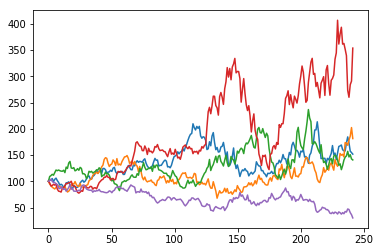

In [69]:
'''
V: Starting Firm Value @ t_0
K: Face Value of Debt @ T (Strike Price) **** Variable not used in the model
sigma: The Volatility of Assets or Firm value for a specified time period
dt: Time Step
iRate: Quoted Annual Interest Rate
num_paths: The number of paths that will be simulated

Notes: Model starts with the given details of Firm value and then generates a monte carlo simulation based on the number of paths,
scaled volatility, time step and interest rate
'''
def merton_model(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
    print('Numerical PD: ', 1 - (np.sum(asset_value[-1, :] > K)/ num_paths), '\n')
    print('Estimated Distribution PD: ', sp.gaussian_kde(np.array(asset_value[-1,:])).integrate_box_1d(-np.inf, K))
    
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, 241, num=241)
    ax.plot(x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)],
             x, asset_value[:,np.random.randint(250000)])
    
    
    return asset_value

simulated_asset_values = merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

In [74]:
def plot_simulation(simulated_values, model_type, num_paths):
    trace0 = go.Scatter(
    y = simulated_values[:,np.random.randint(num_paths)],
    mode = 'lines',
    name = 'Path 1'
    )
    trace1 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 2'
    )
    trace2 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 3'
    )
    trace3 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 4'
    )
    trace4 = go.Scatter(
        y = simulated_values[:,np.random.randint(num_paths)],
        mode = 'lines',
        name = 'Path 5'
    )
    data = [trace0, trace1, trace2, trace3, trace4]
    layout = dict(title = str(model_type) + 'Asset Value Simulation',
                  xaxis = dict(title = 'Time Period in months'),
                  yaxis = dict(title = 'Asset Value'),
                  )

    fig = dict(data=data, layout=layout)
    
    return py.iplot(fig, filename='Credit-Risk' + str(model_type))

In [73]:
plot_simulation(simulated_asset_values, 'Merton Model', num_paths=250000)

C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### (b) Plot Residual Firm Values

In [ ]:
# Calculate the simple residual firm values by subtracting the face value of debt from the simulated asset values
residual_firm_value = simulated_asset_values - 80

# Plotly Histogram chart of the residual asset values @ Maturity (T=T)
data = [go.Histogram(x=residual_firm_value[-1,:])]
layout = dict(title = 'Asset Values at T Histogram',
              xaxis = dict(title = 'Number of observations'),
              yaxis = dict(title = 'Asset Value'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Credit-Risk-Merton_Distribution')

In [ ]:
# Seaborn plot of the residual asset values @ Maturity T=T
sns.distplot(residual_firm_value[-1,:], hist=False, rug=True);

### (c) Default Probability @ T

In [75]:
'''
Notes: Calculates the "Analytical Default Probability" based on the values of N(-d2) derived from the Call option from the Equity
calculation. This accounts for the split sigma's given at 10 year intervals

TODO: Check to see if the variances can be combined or D2's multiplied together
'''

def analytical_default_probability(V_0, K, sigma_10, sigma_20, T, iRate):
    
    d1_10 = (np.log(V_0/K) + (iRate + .5*sigma_10**2)*T)/ (sigma_10*np.sqrt(T))
    d2_10 = d1_10 - (sigma_10)*np.sqrt(T)
    d1_20 = (np.log(V_0/K) + (iRate + .5*sigma_20**2)*T)/ (sigma_20*np.sqrt(T))
    d2_20 = d1_20 - (sigma_20)*np.sqrt(T)
    
    return print('Product of multiple leg Probability of Default: ', (d2_10 + d2_20)/2)
    #print(sp.norm.pdf(d1))
    #print(sp.norm.pdf(d2))
    #print(sp.norm.pdf(-d2))
    #equity_0 = V_0*sp.norm.cdf(d1) - K*np.exp(-iRate*T)*sp.norm.cdf(d2)
    #return ('Call Option Price: ' + str(round(equity_0, 2)),'Probabilty of Default @ T: ' + str(round(sp.norm.cdf(-d2)*100, 2)) + '%')

analytical_default_probability(V_0=100, K=80, sigma_10=.15, sigma_20= .25, T=20, iRate=0.031)

Product of multiple leg Probability of Default:  0.5582937621155915


In [40]:
# Generates a probability distribution based on an array of numbers
kde = sp.gaussian_kde(np.array(simulated_asset_values[-1,:]))

#get probability from the integral of the assumed probability distribution from the ending asset values; from negative infinity to 80
merton_default_probability = kde.integrate_box_1d(-np.inf, 80)
print('Base Model Output: ', merton_default_probability, '\n')
'''
print('PD Output 1: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')
print('PD Output 2: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')
print('PD Output 3: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')
print('PD Output 4: ', sp.gaussian_kde(np.array(
    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80))
'''

Base Model Output:  0.3197564366878493 



"\nprint('PD Output 1: ', sp.gaussian_kde(np.array(\n    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')\nprint('PD Output 2: ', sp.gaussian_kde(np.array(\n    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')\nprint('PD Output 3: ', sp.gaussian_kde(np.array(\n    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80), '\n')\nprint('PD Output 4: ', sp.gaussian_kde(np.array(\n    merton_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)[-1,:])).integrate_box_1d(-np.inf, 80))\n"

### (d) Black Cox Model: Stopping time of default

In [27]:
'''
V: Starting Firm Value @ t_0
K: Face Value of Debt @ T (Strike Price) 
sigma: The Volatility of Assets or Firm value for a specified time period
dt: Time Step
iRate: Quoted Annual Interest Rate
num_paths: The number of paths that will be simulated

Notes: Model starts with the given details of Firm value and then generates a monte carlo simulation based on the number of paths,
scaled volatility, time step and interest rate. The asset values at each path is then compared to the discounted face value of debt (K)
at each time step. If the Assets are less than the discounted fave value of debt then a default at t < T is flagged in a binary a matrix
'''

def black_cox_model(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    non_default_binary = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    non_default_binary[0] = V >= K*np.exp(-iRate*T)
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
        #checks to see if the current asset values are greater than the discounted Face value of debt
        non_default_binary[t] = asset_value[t] > K*np.exp(-iRate*(T-(t*dt)))
        
    # sums up all of the instances where there was not a default; ie. each row is equal to the num_periods + 1 if there was not a default
    binary_default_array = (np.sum(non_default_binary, axis=0)) == (num_periods+1)
    # Returns the percentage of paths that defaulted throught the period of T_0 through T
    print('Numerical PD: ', 1 - (np.sum(binary_default_array)/ num_paths))
    # Multiplies the binary non-default matrix with the asset values matrix at Time = T
    final_values = asset_value[-1,:] * binary_default_array
    return sp.gaussian_kde(final_values).integrate_box_1d(-np.inf, K)

black_cox_default_probability = black_cox_model(V=100, K=80, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

print('Estimated Distribution PD Model 2: ', black_cox_default_probability)

Numerical PD:  0.499352
Estimated Distribution PD Model 2:  0.5093476458550831


### (f) Changing the debt structure to equal out the probabilities

In [39]:
def merton_model_prob_default(V, K, sigma, T, dt, iRate, num_paths):
    num_periods = int(T*dt**-1)
    #Creates a matrix filled with zeros; Rows: num_paths, Columns: num_periods
    asset_value = np.zeros((num_periods + 1, int(num_paths)))
    asset_value[0] = V
    for t in range(1, num_periods+1):
        if t > num_periods/2:
            sigma = .25
        # The stochastic equation for simulating the firm value
        asset_value[t] = asset_value[t-1]*np.exp((iRate -.5*sigma**2)*dt + sigma*np.random.randn(num_paths)*np.sqrt(dt))
    # creates a PDF from the data and then integrates over that PDF from negative infinity to K to find the probability of falling in this region
    print('Numerical PD: ', 1 - (np.sum(asset_value[-1, :] > K)/ num_paths), '\n')
    kde = sp.gaussian_kde(np.array(asset_value[-1,:]))
    return kde.integrate_box_1d(-np.inf, K)

def search_probability_merton(K):
    #kde = sp.gaussian_kde(np.array(simulated_asset_values[-1,:]))
    return sp.gaussian_kde(np.array(simulated_asset_values[-1,:])).integrate_box_1d(-np.inf, K)

'''
Sets up the optimization problem between the Merton and Black Cox Model.

The function takes the previously simulated values of the Merton Model and locks the PD.
A minimization objective function is run against the locked Merton PD and the variable Black Cox PD by changing the leverage amount
'''
def probability_errors(debt_level):
    black_cox= black_cox_model(V=100, K= debt_level, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)
    merton= merton_default_probability#search_probability_merton(debt_level)#merton_model_prob_default(V=100, K=debt_level, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)
    #merton_default_probability
    error = (merton - black_cox)**2
    print('Debt: ', debt_level, '\nError: ', error)
    return error
parameters = 80

In [38]:
'''
This is the debt level to tie out to the merton model numerical default probability
'''
black_cox_model(V=100, K= 57.5, sigma=.15, T=20, dt=1/12, iRate=0.031, num_paths=250000)

Numerical PD:  0.324684


0.3407942405156964

In [32]:
'''
debt level of 54.57497857 for changing K only in BC to match the Locked K and values of Merton Model: 3.2476042971524785e-06 error
'''
res = minimize(fun=probability_errors, x0=parameters, bounds=((0, 200),))

Numerical PD:  0.498784
Debt:  [80.] 
Error:  0.03564809722213721
Numerical PD:  0.49888
Debt:  [80.00000001] 
Error:  0.03572259105426367
Numerical PD:  0.0
Debt:  [0.] 
Error:  0.09581127529990383
Numerical PD:  0.0
Debt:  [1.e-08] 
Error:  0.09581838931405198
Numerical PD:  0.300928
Debt:  [54.57497857] 
Error:  3.2476042971524785e-06
Numerical PD:  0.30001599999999995
Debt:  [54.57497858] 
Error:  7.879395396095426e-06
Numerical PD:  0.438628
Debt:  [71.79655548] 
Error:  0.01710057707529696
Numerical PD:  0.43701199999999996
Debt:  [71.79655549] 
Error:  0.0167128780044887
Numerical PD:  0.462572
Debt:  [75.35402541] 
Error:  0.02370323775552272
Numerical PD:  0.46551600000000004
Debt:  [75.35402542] 
Error:  0.02457189219680858
Numerical PD:  0.497576
Debt:  [79.82047836] 
Error:  0.03520315126122413
Numerical PD:  0.49682000000000004
Debt:  [79.82047837] 
Error:  0.035000849595356515
Numerical PD:  0.497784
Debt:  [79.9012157] 
Error:  0.03538954384090175
Numerical PD:  0.496851

### (h) Change in Defualt Probabilities with dt = 1

In [41]:
print('Black Cox Default Probability (dt = 1/12): ', black_cox_default_probability, '\n')
print('Black Cox Default Probability (dt = 1): ', black_cox_model(V=100, K=80, sigma=.15, T=20, dt=1, iRate=0.031, num_paths=250000), '\n')
print('Merton Default Probability (dt = 1/12): ', merton_default_probability, '\n')
print('Merton Default Probability (dt = 1): ', merton_model_prob_default(V=100, K=80, sigma=.15, T=20, dt=1, iRate=0.031, num_paths=250000))

Black Cox Default Probability (dt = 1/12):  0.5093476458550831 

Numerical PD:  0.44832399999999994
Black Cox Default Probability (dt = 1):  0.46484196882814244 

Merton Default Probability (dt = 1/12):  0.3197564366878493 

Numerical PD:  0.325144 

Merton Default Probability (dt = 1):  0.3204155722447783


# (ii) Merton Model Credit Spreads

### (a) Credit Spread Function of time to maturity

In [92]:
firm_value = [80, 90, 125, 180]
time = np.arange(0.5, 10.5, 0.5)

def spreads(firm_values, maturity, iRate, fv_debt, sigma_asset):
    spread_matrix = []
    for value in firm_value:
        spread_list = []
        for T in maturity:
            d1 = (np.log(value/fv_debt) + (iRate + .5*sigma_asset**2)*T)/ (sigma_asset*np.sqrt(T))
            d2 = d1 - (sigma_asset)*np.sqrt(T)
            
            #risky_bond_value = fv_debt*np.exp((-iRate)*T) - fv_debt*np.exp((-iRate)*T)*(-d2) - value*(-d1)
            risky_bond_value = value*d1 - fv_debt*np.exp((-iRate)*T)*d2
            risky_yield = 1/T * np.log(fv_debt/risky_bond_value)
            spread = risky_yield - iRate*T
            spread_list.append(spread)
        spread_matrix.append(spread_list)
    return pd.DataFrame(data=np.array(spread_matrix)).T

In [93]:
spreads(firm_values=firm_value, maturity=time, iRate=0.028, fv_debt=95, sigma_asset=.23)

,0,1,2,3
0,2.472669,3.568332,0.503798,-2.727226
1,1.209356,1.469862,0.307902,-1.128228
2,0.744221,0.833417,0.175781,-0.695389
3,0.502023,0.533050,0.091922,-0.512202
4,0.352283,0.358646,0.033551,-0.418596
5,0.249292,0.243887,-0.010389,-0.366072
6,0.173006,0.161634,-0.045546,-0.335387
7,0.113306,0.098853,-0.075038,-0.317532
8,0.064558,0.048562,-0.100702,-0.307778
9,0.023386,0.006710,-0.123683,-0.303433


In [112]:
Lambda = 1
mean_j = 0.05
sigma_j = .4
T = 1
fv_debt = 100
value = 100
iRate = 0.05


print('poission draw: ', np.random.poisson(lam=Lambda))
k_mean = np.exp(mean_j + 0.5*sigma_j**2) - 1
print('K mean: ', k_mean)
jump_size = mean_j*np.exp(-0.5*sigma_j**2 + sigma_j*np.random.normal())
print('Jump Size: ', jump_size)



for k in range(0, 101): #np.random.poisson(lam=Lambda, size=250000):
    price = 0
    sigma_k = np.sqrt(iRate+k*sigma_j**2/T)
    r_k = iRate - Lambda*(mean_j - 1) + k*np.log(mean_j)/T
    
    d1 = (np.log(value/fv_debt) + (r_k + .5*sigma_k**2)*T)/ (sigma_k*np.sqrt(T))
    d2 = d1 - (sigma_k)*np.sqrt(T)
    
    price+=((np.exp(mean_j*Lambda*T)*(mean_j*Lambda*T)**k) / np.math.factorial(k))*(value*d1 - fv_debt*np.exp((-r_k)*T)*d2)
print(price)

poission draw:  0
K mean:  0.13882838332462177
Jump Size:  0.05723376460739085
3.1713831083491345e-155


# (iii) Merton Model Extensions: Merton Model with Jump Processes

Numerical PD:  0.38314800000000004 

Estimated Distribution PD:  0.3805295482379425


C:\Users\austi\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



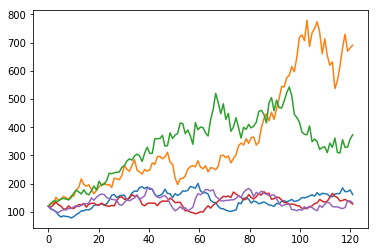

In [76]:
def merton_model_jump_process(V, K, sigma, T, dt, iRate, num_paths, jumps_mu, jumps_sigma, Lambda):
    num_periods = int(T*dt**-1)
    simulated_paths = np.zeros([num_periods+1, num_paths])
    # Replace the first column of the array with the vector of initial price S
    simulated_paths[0] = V
    
    Z_1 = np.random.normal(size=[num_periods+1, num_paths])
    Z_2 = np.random.normal(size=[num_periods+1, num_paths])
    Poisson = np.random.poisson(Lambda*dt, [num_periods+1, num_paths])
    
    rj = Lambda*(np.exp(jumps_mu + 0.5*jumps_sigma**2)-1)

    for t in range(1, num_periods + 1):
        #simulated_paths[t] = simulated_paths[t-1]*np.exp((iRate - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_1[t] + jumps_mu*Poisson[1] + np.sqrt(jumps_sigma**2) * np.sqrt(Poisson[t])*Z_2[t])
        simulated_paths[t] = simulated_paths[t-1]*(np.exp((iRate - rj - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_1[t]) + (np.exp(jumps_mu + jumps_sigma*Z_2[t])-1)*Poisson[t])
    asset_values_at_T = simulated_paths[-1, :]
    
    print('Numerical PD: ', 1 - (np.sum(asset_values_at_T > K)/ num_paths), '\n')
    print('Estimated Distribution PD: ', sp.gaussian_kde(np.array(asset_values_at_T)).integrate_box_1d(-np.inf, K))
    
    fig = plt.figure()
    ax = plt.axes()
    x = np.linspace(0, num_periods+1, num=num_periods+1)
    ax.plot(x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)],
             x, simulated_paths[:,np.random.randint(num_paths)])
    
    
    return simulated_paths

plot_simulation(merton_model_jump_process(V=120, K=95, iRate=0.028, sigma=.23, T= 10, dt=1/12, num_paths=250000, jumps_mu=0.05, jumps_sigma=0.20, Lambda=.1),
                'Merton Model with Jumps', num_paths=250000)